In [ ]:
import os
import math
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# Constants
SOURCE_DATA_DIR = '/content/drive/Shareddrives/ML Dataset/'
ROOT_DIR = '/content/dataset'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
VALID_DIR = os.path.join(ROOT_DIR, 'validation')
EVAL_DIR = os.path.join(ROOT_DIR, 'evaluation')
SPLIT_SIZE = 0.75
BATCH_SIZE = 32
TARGET_SIZE = (450, 450)
EPOCHS = 200
STEPS = 10
SAVED_MODEL_PATH = '/content/drive/Shareddrives/ML Dataset/transfer_learning/models/mobilenet_v3/1/'


In [ ]:
class MyCallback(Callback):
    def __init__(self, thereshold):
        super().__init__()
        self.thereshold = thereshold

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > self.thereshold:
            print("\nReached target metric. Stopping training!")
            self.model.stop_training = True


In [ ]:
class PrintLrCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    lr = float(K.get_value(self.model.optimizer.lr))
    print(f"Epoch {epoch+1}: Learning rate = {lr}")

In [ ]:
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

In [ ]:
# Function to create directories
def create_dirs(path, dir_names):
    for dir_name in dir_names:
        os.makedirs(os.path.join(path, dir_name), exist_ok=True)

In [ ]:
# Function to split data
def split_data(source_dir, train_dir, valid_dir, split_size):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_point = int(len(files) * split_size)
    for i, file in enumerate(files):
        if os.path.getsize(os.path.join(source_dir, file)) > 0:
            if i < split_point:
                shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
            else:
                shutil.copy(os.path.join(source_dir, file), os.path.join(valid_dir, file))

In [ ]:
# Function to create data generators
def create_generators(train_dir, valid_dir, target_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0/255., shear_range=0.1, rotation_range=5, horizontal_flip=True)
    valid_datagen = ImageDataGenerator(rescale=1.0/255.)
    train_generator = train_datagen.flow_from_directory(directory=train_dir, batch_size=batch_size, class_mode='categorical', target_size=target_size)
    valid_generator = valid_datagen.flow_from_directory(directory=valid_dir, batch_size=batch_size, class_mode='categorical', target_size=target_size)
    return train_generator, valid_generator

In [ ]:
# Function to create model
def create_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
# Function to create transfer learning model
def create_transfer_model(input_shape, SAVED_MODEL_PATH):
    model = Sequential([
        hub.KerasLayer(SAVED_MODEL_PATH, input_shape=input_shape, trainable=False),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

In [ ]:
# Function to plot metrics
def plot_metrics(history):
    metrics = ['accuracy', 'loss']
    for metric in metrics:
        plt.plot(history.history[metric], 'r', label='Training ' + metric)
        plt.plot(history.history['val_' + metric], 'b', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()
        plt.show()

In [ ]:
# Function to evaluate model
def evaluate_model(model, eval_dir, datasets, target_size, batch_size):
    eval_datagen = ImageDataGenerator(rescale=1.0/255.)
    for dataset in datasets:
        shutil.rmtree(eval_dir, ignore_errors=True)
        shutil.copytree(VALID_DIR, eval_dir)
        for directory in os.listdir(eval_dir):
            if directory != dataset:
                for file in os.listdir(os.path.join(eval_dir, directory))[1:]:
                    os.remove(os.path.join(eval_dir, directory, file))
        eval_generator = eval_datagen.flow_from_directory(directory=eval_dir, batch_size=batch_size, class_mode='categorical', target_size=target_size)
        print(f"Loss and Accuracy of {dataset}:")
        print(model.evaluate(eval_generator))
        print()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create directories
if os.path.exists(ROOT_DIR):
  shutil.rmtree(ROOT_DIR)

dir_names = ['without_both', 'either_banner_or_logo', 'both_banner_and_logo']
create_dirs(TRAIN_DIR, dir_names)
create_dirs(VALID_DIR, dir_names)

# Split data
for dir_name in dir_names:
    split_data(os.path.join(SOURCE_DATA_DIR, dir_name), os.path.join(TRAIN_DIR, dir_name), os.path.join(VALID_DIR, dir_name), SPLIT_SIZE)

# Create and compile conv model

In [ ]:
clear_session()

In [ ]:
TARGET_SIZE = (450, 450)

train_generator, valid_generator = create_generators(TRAIN_DIR, VALID_DIR, TARGET_SIZE, BATCH_SIZE)

Found 1295 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


In [ ]:
model = create_model(TARGET_SIZE + (3,))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 224, 224, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 54, 54, 64)        0

Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 1.4101 - accuracy: 0.3693
Epoch 1: val_accuracy improved from -inf to 0.34954, saving model to /content/drive/Shareddrives/ML Dataset/export/models/conv/1/
15/15 [==============================] - 42s 3s/step - loss: 1.4101 - accuracy: 0.3693 - val_loss: 1.0433 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.4190
Epoch 2: val_accuracy improved from 0.34954 to 0.39815, saving model to /content/drive/Shareddrives/ML Dataset/export/models/conv/1/
15/15 [==============================] - 34s 2s/step - loss: 1.0396 - accuracy: 0.4190 - val_loss: 1.0326 - val_accuracy: 0.3981 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - ETA: 0s - loss: 0.9700 - accuracy: 0.5083
Epoch 3: val_accuracy improved from 0.39815 to 0.53241, saving model to /content/drive/Shareddrives/ML Dataset/export/models/conv/1/
15/15 [============================

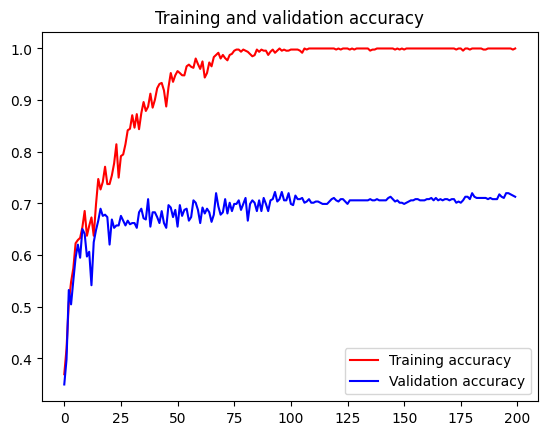

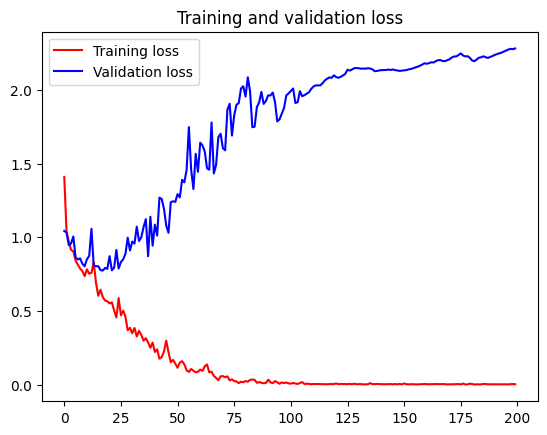

Found 124 images belonging to 3 classes.
Loss and Accuracy of without_both:
4/4 [==============================] - 1s 316ms/step - loss: 1.9236 - accuracy: 0.7661
[1.9236178398132324, 0.7661290168762207]

Found 165 images belonging to 3 classes.
Loss and Accuracy of either_banner_or_logo:
6/6 [==============================] - 2s 307ms/step - loss: 2.0014 - accuracy: 0.7333
[2.0013742446899414, 0.7333333492279053]

Found 149 images belonging to 3 classes.
Loss and Accuracy of both_banner_and_logo:
5/5 [==============================] - 2s 447ms/step - loss: 2.8950 - accuracy: 0.6443
[2.894962787628174, 0.6442952752113342]



In [ ]:
# Train model
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    steps_per_epoch=STEPS,
                    callbacks=[ModelCheckpoint(r'/content/drive/Shareddrives/ML Dataset/export/models/conv/2/', monitor='val_accuracy', save_best_only=True, verbose=1),
                               ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=5, min_lr=0.00005)])

# Plot metrics
plot_metrics(history)

# Evaluate model
evaluate_model(model, EVAL_DIR, dir_names, TARGET_SIZE, BATCH_SIZE)

# Create and train transfer learning model
## MobileNet


In [ ]:
TARGET_SIZE = (224, 224)
train_generator, valid_generator = create_generators(TRAIN_DIR, VALID_DIR, TARGET_SIZE, BATCH_SIZE)

Found 1295 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


In [ ]:
SAVED_MODEL_PATH = '/content/drive/Shareddrives/ML Dataset/transfer_learning/models/mobilenet_v3/1/'

transfer_mobilenet = create_transfer_model(TARGET_SIZE + (3,), SAVED_MODEL_PATH)

transfer_mobilenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense_4 (Dense)             (None, 512)               513024    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 6023276 (22.98 MB)
Trainable params: 514563 (1.96 MB)
Non-trainable params: 5508713 (21.01 MB)
_________________________________________________________________


Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 1.6248 - accuracy: 0.5594
Epoch 1: val_accuracy improved from -inf to 0.68519, saving model to /content/drive/Shareddrives/ML Dataset/export/models/mobilenet_tl/1/
10/10 [==============================] - 23s 2s/step - loss: 1.6248 - accuracy: 0.5594 - val_loss: 1.1653 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.6781
Epoch 2: val_accuracy improved from 0.68519 to 0.69676, saving model to /content/drive/Shareddrives/ML Dataset/export/models/mobilenet_tl/1/
10/10 [==============================] - 15s 2s/step - loss: 1.0446 - accuracy: 0.6781 - val_loss: 0.8114 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.7162
Epoch 3: val_accuracy improved from 0.69676 to 0.77546, saving model to /content/drive/Shareddrives/ML Dataset/export/models/mobilenet_tl/1/
10/10 [====

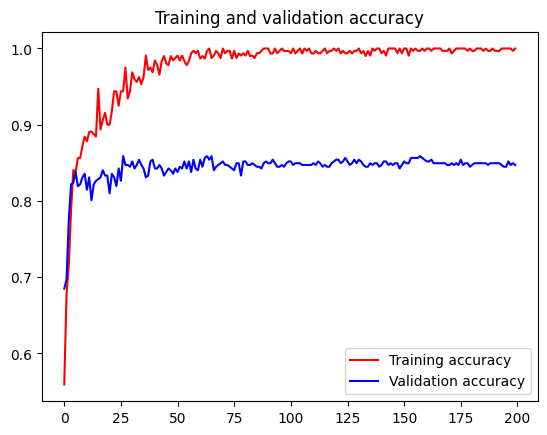

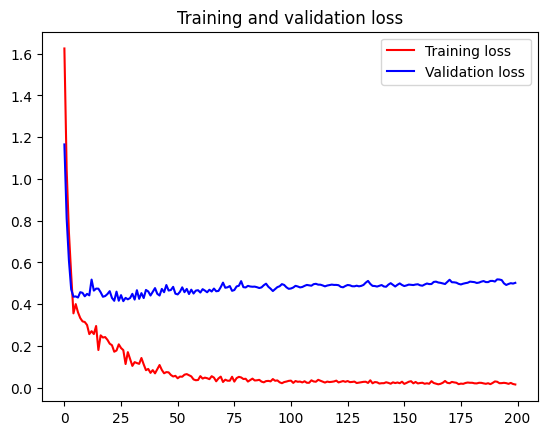

Found 124 images belonging to 3 classes.
Loss and Accuracy of without_both:
4/4 [==============================] - 1s 169ms/step - loss: 0.2762 - accuracy: 0.9032
[0.2762172222137451, 0.9032257795333862]

Found 165 images belonging to 3 classes.
Loss and Accuracy of either_banner_or_logo:
6/6 [==============================] - 1s 133ms/step - loss: 0.7035 - accuracy: 0.7697
[0.7035030722618103, 0.7696969509124756]

Found 149 images belonging to 3 classes.
Loss and Accuracy of both_banner_and_logo:
5/5 [==============================] - 2s 473ms/step - loss: 0.4889 - accuracy: 0.8658
[0.48893046379089355, 0.8657718300819397]



In [ ]:
# Train transfer learning model
transfer_mobilenet_history = transfer_mobilenet.fit(train_generator,
                                                    epochs=EPOCHS,
                                                    validation_data=valid_generator,
                                                    steps_per_epoch=STEPS,
                                                    callbacks=[ModelCheckpoint(r'/content/drive/Shareddrives/ML Dataset/export/models/mobilenet_tl/2/', monitor='val_accuracy', save_best_only=True, verbose=1),
                                                               ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=5, min_lr=0.00005)])


# Plot metrics
plot_metrics(transfer_mobilenet_history)

# Evaluate transfer learning model
evaluate_model(transfer_mobilenet, EVAL_DIR, dir_names, TARGET_SIZE, BATCH_SIZE)

# Inception

In [ ]:
TARGET_SIZE = (299, 299)
train_generator, valid_generator = create_generators(TRAIN_DIR, VALID_DIR, TARGET_SIZE, BATCH_SIZE)

Found 1295 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


In [ ]:
SAVED_MODEL_PATH = '/content/drive/Shareddrives/ML Dataset/transfer_learning/models/inception_v3/1/'

transfer_inception = create_transfer_model(TARGET_SIZE + (3,), SAVED_MODEL_PATH)

transfer_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 512)               513024    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24368396 (92.96 MB)
Trainable params: 514563 (1.96 MB)
Non-trainable params: 23853833 (91.00 MB)
_________________________________________________________________


Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 1.2571 - accuracy: 0.5719
Epoch 1: val_accuracy improved from -inf to 0.71759, saving model to /content/drive/Shareddrives/ML Dataset/export/models/inception_tl/1/
10/10 [==============================] - 43s 3s/step - loss: 1.2571 - accuracy: 0.5719 - val_loss: 0.7712 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.7344
Epoch 2: val_accuracy improved from 0.71759 to 0.75926, saving model to /content/drive/Shareddrives/ML Dataset/export/models/inception_tl/1/
10/10 [==============================] - 22s 2s/step - loss: 0.7125 - accuracy: 0.7344 - val_loss: 0.6278 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7437
Epoch 3: val_accuracy improved from 0.75926 to 0.80324, saving model to /content/drive/Shareddrives/ML Dataset/export/models/inception_tl/1/
10/10 [====

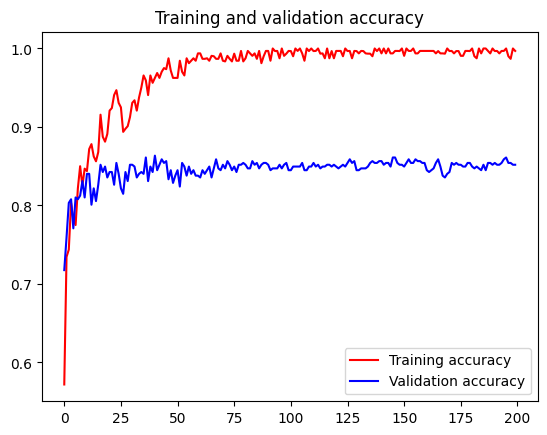

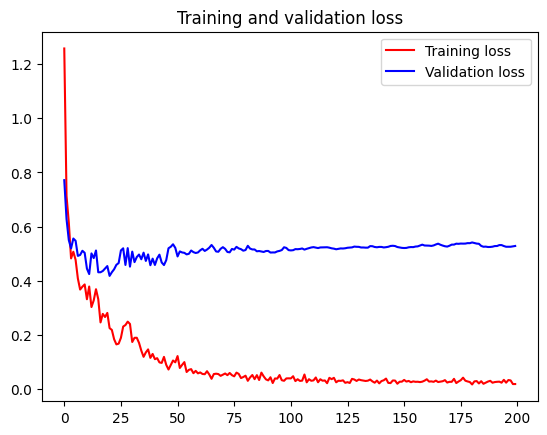

Found 124 images belonging to 3 classes.
Loss and Accuracy of without_both:
4/4 [==============================] - 3s 943ms/step - loss: 0.3866 - accuracy: 0.9194
[0.3865841329097748, 0.9193548560142517]

Found 165 images belonging to 3 classes.
Loss and Accuracy of either_banner_or_logo:
6/6 [==============================] - 3s 422ms/step - loss: 0.6813 - accuracy: 0.7939
[0.6813414692878723, 0.7939394116401672]

Found 149 images belonging to 3 classes.
Loss and Accuracy of both_banner_and_logo:
5/5 [==============================] - 4s 822ms/step - loss: 0.5497 - accuracy: 0.8523
[0.5496981143951416, 0.8523489832878113]



In [ ]:
# Train transfer learning model
transfer_inception_history = transfer_inception.fit(train_generator,
                                                    epochs=EPOCHS,
                                                    validation_data=valid_generator,
                                                    steps_per_epoch=STEPS,
                                                    callbacks=[ModelCheckpoint(r'/content/drive/Shareddrives/ML Dataset/export/models/inception_tl/2/', monitor='val_accuracy', save_best_only=True, verbose=1),
                                                    ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=5, min_lr=0.00005)])



# Plot metrics
plot_metrics(transfer_inception_history)

# Evaluate transfer learning model
evaluate_model(transfer_inception, EVAL_DIR, dir_names, TARGET_SIZE, BATCH_SIZE)

## ResNet


In [ ]:
TARGET_SIZE = (224, 224)
train_generator, valid_generator = create_generators(TRAIN_DIR, VALID_DIR, TARGET_SIZE, BATCH_SIZE)

Found 1295 images belonging to 3 classes.
Found 432 images belonging to 3 classes.


In [ ]:
SAVED_MODEL_PATH = '/content/drive/Shareddrives/ML Dataset/transfer_learning/models/resnet_v2/1/'

transfer_resnet = create_transfer_model(TARGET_SIZE + (3,), SAVED_MODEL_PATH)

transfer_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              60382697  
                                                                 
 dense_2 (Dense)             (None, 512)               513024    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 60897260 (232.30 MB)
Trainable params: 514563 (1.96 MB)
Non-trainable params: 60382697 (230.34 MB)
_________________________________________________________________


Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 1.1415 - accuracy: 0.6125
Epoch 1: val_accuracy improved from -inf to 0.67130, saving model to /content/drive/Shareddrives/ML Dataset/export/models/resnet_tl/1/
10/10 [==============================] - 49s 4s/step - loss: 1.1415 - accuracy: 0.6125 - val_loss: 1.0252 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.7294
Epoch 2: val_accuracy improved from 0.67130 to 0.73843, saving model to /content/drive/Shareddrives/ML Dataset/export/models/resnet_tl/1/
10/10 [==============================] - 30s 3s/step - loss: 0.8396 - accuracy: 0.7294 - val_loss: 0.8197 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 3/200
10/10 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.7156
Epoch 3: val_accuracy did not improve from 0.73843
10/10 [==============================] - 13s 1s/step - loss: 0.7898 - accuracy: 0.7156 - val_loss: 0.8684 -

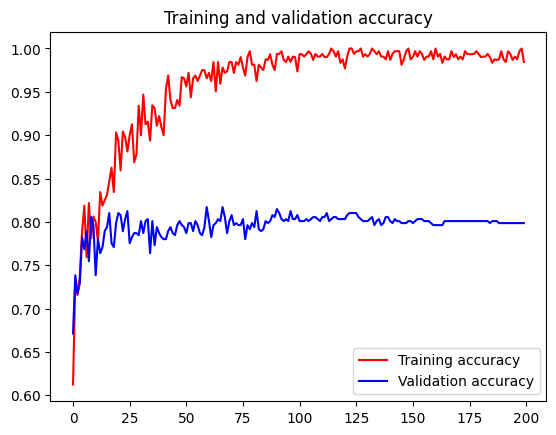

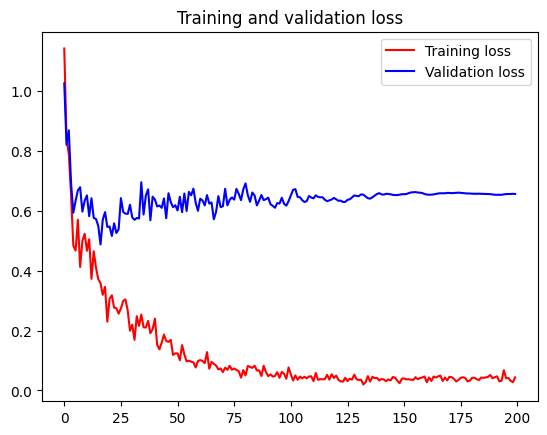

Found 124 images belonging to 3 classes.
Loss and Accuracy of without_both:
4/4 [==============================] - 3s 695ms/step - loss: 0.5110 - accuracy: 0.8871
[0.5109528303146362, 0.8870967626571655]

Found 165 images belonging to 3 classes.
Loss and Accuracy of either_banner_or_logo:
6/6 [==============================] - 2s 323ms/step - loss: 0.9958 - accuracy: 0.6909
[0.9957569241523743, 0.6909090876579285]

Found 149 images belonging to 3 classes.
Loss and Accuracy of both_banner_and_logo:
5/5 [==============================] - 3s 630ms/step - loss: 0.4252 - accuracy: 0.8389
[0.4251663088798523, 0.8389261960983276]



In [ ]:
# Train transfer learning model
transfer_resnet_history = transfer_resnet.fit(train_generator,
                                                    epochs=EPOCHS,
                                                    validation_data=valid_generator,
                                                    steps_per_epoch=STEPS,
                                                    callbacks=[ModelCheckpoint(r'/content/drive/Shareddrives/ML Dataset/export/models/resnet_tl/2/', monitor='val_accuracy', save_best_only=True, verbose=1),
                                                    ReduceLROnPlateau(monitor='accuracy', factor=0.8, verbose=1, patience=5, min_lr=0.000005)])



# Plot metrics
plot_metrics(transfer_resnet_history)

# Evaluate transfer learning model
evaluate_model(transfer_resnet, EVAL_DIR, dir_names, TARGET_SIZE, BATCH_SIZE)